In [106]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from collections import defaultdict
from PIL import Image
import numpy as np
import cv2

### 경로 설정

In [107]:
# 학습 데이터의 경로와 정보를 가진 파일의 경로를 설정
traindata_dir = "./data/train"
traindata_info_file = "./data/train.csv"

# 테스트 데이터의 경로와 정보를 가진 파일의 경로를 설정
testdata_dir = "./data/test"
testdata_info_file = "./data/test.csv"

### 파일 정보 확인

In [108]:
# 학습 데이터의 class, image path, target에 대한 정보가 들어있는 csv파일을 읽기
train_data = pd.read_csv(traindata_info_file)

# 테스트 데이터
test_data = pd.read_csv(testdata_info_file)

In [109]:
# 학습 데이터의 정보를 출력
train_info = train_data.info()
train_head = train_data.head()

train_info, train_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15021 entries, 0 to 15020
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   class_name  15021 non-null  object
 1   image_path  15021 non-null  object
 2   target      15021 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 352.2+ KB


(None,
   class_name                image_path  target
 0  n01872401  n01872401/sketch_50.JPEG      59
 1  n02417914  n02417914/sketch_11.JPEG     202
 2  n02106166   n02106166/sketch_3.JPEG     138
 3  n04235860   n04235860/sketch_2.JPEG     382
 4  n02056570  n02056570/sketch_40.JPEG      80)

In [110]:
# 테스트 데이터의 정보를 출력
test_info = test_data.info()
test_head = test_data.head()

test_info, test_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10014 entries, 0 to 10013
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  10014 non-null  object
dtypes: object(1)
memory usage: 78.4+ KB


(None,
   image_path
 0     0.JPEG
 1     1.JPEG
 2     2.JPEG
 3     3.JPEG
 4     4.JPEG)

In [111]:
data_description = train_data.describe(include='all')
data_description

,class_name,image_path,target
count,15021,15021,15021.000000
unique,500,15021,NaN
top,n04004767,n01688243/sketch_31.JPEG,NaN
freq,31,1,NaN
mean,NaN,NaN,249.989082
std,NaN,NaN,144.471752
min,NaN,NaN,0.000000
25%,NaN,NaN,125.000000
50%,NaN,NaN,250.000000
75%,NaN,NaN,375.000000


In [112]:
# target의 unique한 값의 개수 출력
unique_class = train_data['class_name'].nunique()
unique_class

500

C:\Users\User\AppData\Local\Temp\ipykernel_9640\2890714918.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=train_data['class_name'], order=train_data['class_name'].value_counts().index, palette='viridis')


Text(0, 0.5, 'Class Name')

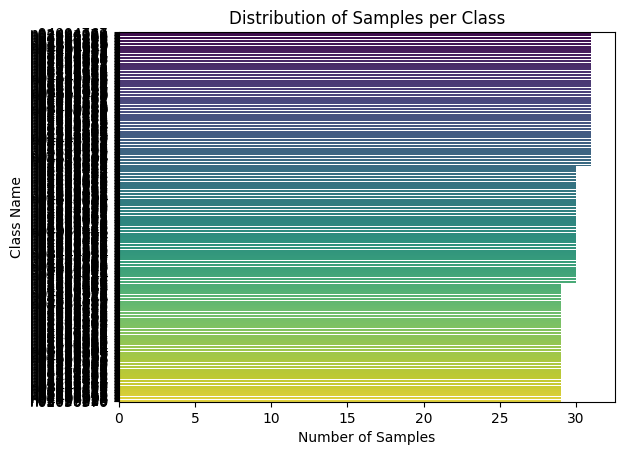

In [113]:
# class_name별로 샘플의 개수를 출력
sns.countplot(y=train_data['class_name'], order=train_data['class_name'].value_counts().index, palette='viridis')
plt.title('Distribution of Samples per Class')
plt.xlabel('Number of Samples')
plt.ylabel('Class Name')

C:\Users\User\AppData\Local\Temp\ipykernel_9640\2980358208.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(train_data['target'], bins=500, kde=False, palette='viridis')


Text(0, 0.5, 'Number of Samples')

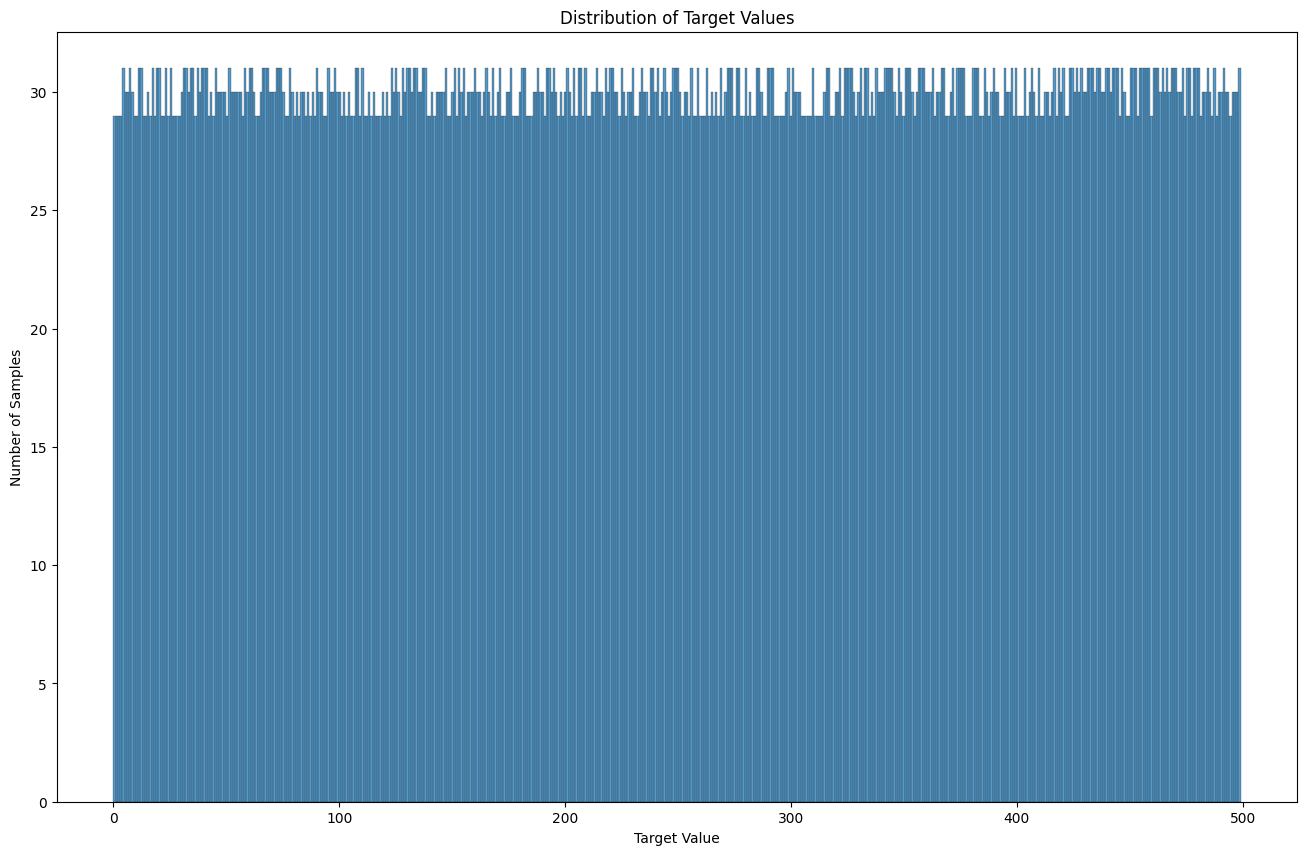

In [114]:
# target 값의 분포를 출력
plt.figure(figsize=(16, 10))
sns.histplot(train_data['target'], bins=500, kde=False, palette='viridis')
plt.title('Distribution of Target Values')
plt.xlabel('Target Value')
plt.ylabel('Number of Samples')

Class name 분포
- 대부분 29에서 31 사이의 값을 가지고 있음

Target 분포
- 대부분 29에서 31 사이의 값을 가지고 있음

데이터 셋 전반적으로 Class name, Target에 대해서 29~31개의 값을 가지고 있음.

### 이미지 데이터 불러오기

In [115]:
# glob을 이용하여 이미지 파일의 경로를 읽어옴
train_images = glob(traindata_dir + "/*/*")
test_images = glob(testdata_dir + "/*")
print(f"Number of train images: {len(train_images)}")
print(f"Number of test images: {len(test_images)}")

Number of train images: 15021
Number of test images: 10014


In [116]:
image_prop = defaultdict(list) # 이미지의 속성을 저장할 딕셔너리 생성

# 이미지의 경로를 이용하여 속성 추출
for i, path in enumerate(train_images):
    with Image.open(path) as img:
        image_prop['height'].append(img.height)
        image_prop['width'].append(img.width)
        image_prop['img_aspect_ratio'].append(img.width / img.height)  # aspect_ratio = 종횡비 즉, 이미지의 가로 세로 비율
        image_prop['mode'].append(img.mode)
        image_prop['format'].append(img.format)
        image_prop['size'].append(round(os.path.getsize(path) / 1e6, 2))
    image_prop['path'].append(path)
    image_prop['image_path'].append(path.split('\\')[-2] + "/" + path.split('\\')[-1])

image_data = pd.DataFrame(image_prop)

image_data = image_data.merge(train_data, on='image_path')
image_data.head()

,height,width,img_aspect_ratio,mode,format,size,path,image_path,class_name,target
0,800,800,1.000000,RGB,JPEG,0.08,./data/train\n01443537\sketch_0.JPEG,n01443537/sketch_0.JPEG,n01443537,0
1,671,800,1.192250,RGB,JPEG,0.11,./data/train\n01443537\sketch_10.JPEG,n01443537/sketch_10.JPEG,n01443537,0
2,590,678,1.149153,RGB,JPEG,0.12,./data/train\n01443537\sketch_11.JPEG,n01443537/sketch_11.JPEG,n01443537,0
3,470,450,0.957447,L,JPEG,0.09,./data/train\n01443537\sketch_12.JPEG,n01443537/sketch_12.JPEG,n01443537,0
4,628,800,1.273885,RGB,JPEG,0.05,./data/train\n01443537\sketch_13.JPEG,n01443537/sketch_13.JPEG,n01443537,0


In [117]:
image_data['mode'].value_counts() 

mode
RGB    12443
L       2578
Name: count, dtype: int64

- image_data : 각 이미지에 대한 높이, 너비, 종횡비, 모드(컬러, 흑백), 파일 형식, 파일크기(MB), 전체 경로, 상대경로, 클래스명, 타깃값에 대한 정보가 담긴 데이터프레임
- train_image의 mode 분포 비율은 약 6 : 1

In [118]:
# 이미지의 특징을 추출하는 함수
def extract_image_features(image_path):
    """
    Extracts features from an image.
    Args:
        image_path (str): Path to the image file.
    Returns:
        width (int): Width of the image.
        height (int): Height of the image.
        mode (str): Mode of the image.
        format (str): Format of the image.
        size (int): Size of the image.
        mean_red (float): Mean of red channel.
        mean_green (float): Mean of green channel.
        mean_blue (float): Mean of blue channel.
    """
    try:
        with Image.open(image_path) as img:
            mode = img.mode  # 원래 모드를 저장
            width, height = img.size
            img_array = np.array(img)
            
            # RGB 모드인 경우만 평균값 계산
            if mode == 'RGB':
                mean_red = np.mean(img_array[:, :, 0])
                mean_green = np.mean(img_array[:, :, 1])
                mean_blue = np.mean(img_array[:, :, 2])
            else:
                mean_red = mean_green = mean_blue = None  # RGB가 아니면 None 처리
            
            format = image_path.split('.')[-1].upper()
            return width, height, mode, format, os.path.getsize(image_path), mean_red, mean_green, mean_blue
    except Exception as e:
        return None, None, None, None, None, None, None, None

image_prop = defaultdict(list) # 이미지의 속성을 저장할 딕셔너리 생성

for i, path in enumerate(train_images):
    width, height, mode, format, size, mean_red, mean_green, mean_blue = extract_image_features(path)
    image_prop['height'].append(height)
    image_prop['width'].append(width)
    image_prop['mode'].append(mode)
    image_prop['format'].append(format)
    image_prop['size'].append(round(size / 1e6, 2) if size else None)
    image_prop['mean_red'].append(mean_red)
    image_prop['mean_green'].append(mean_green)
    image_prop['mean_blue'].append(mean_blue)
    image_prop['path'].append(path)
    image_prop['image_path'].append(path.split('\\')[-2] + "/" + path.split('\\')[-1])

image_data = pd.DataFrame(image_prop)
image_data['img_aspect_ratio'] = image_data['width'] / image_data['height'] # aspect_ratio = 종횡비 즉, 이미지의 가로 세로 비율

image_data = image_data.merge(train_data, on='image_path')
image_data.sort_values(by='target', inplace=True)
image_data.head()


,height,width,mode,format,size,mean_red,mean_green,mean_blue,path,image_path,img_aspect_ratio,class_name,target
9,426,650,RGB,JPEG,0.06,234.734673,234.540784,233.710744,./data/train\n01443537\sketch_19.JPEG,n01443537/sketch_19.JPEG,1.525822,n01443537,0
8,470,450,L,JPEG,0.13,NaN,NaN,NaN,./data/train\n01443537\sketch_17.JPEG,n01443537/sketch_17.JPEG,0.957447,n01443537,0
3,470,450,L,JPEG,0.09,NaN,NaN,NaN,./data/train\n01443537\sketch_12.JPEG,n01443537/sketch_12.JPEG,0.957447,n01443537,0
1,671,800,RGB,JPEG,0.11,185.432288,185.726542,187.349311,./data/train\n01443537\sketch_10.JPEG,n01443537/sketch_10.JPEG,1.192250,n01443537,0
5,483,590,RGB,JPEG,0.07,239.440720,239.440720,239.440720,./data/train\n01443537\sketch_14.JPEG,n01443537/sketch_14.JPEG,1.221532,n01443537,0


In [119]:
image_data['mode'].value_counts() 

mode
RGB    12443
L       2578
Name: count, dtype: int64

In [120]:
image_data['target'].value_counts().sort_index()

target
0      29
1      29
2      29
3      29
4      31
       ..
495    29
496    30
497    30
498    30
499    31
Name: count, Length: 500, dtype: int64

### 이미지 파일 크기 분석

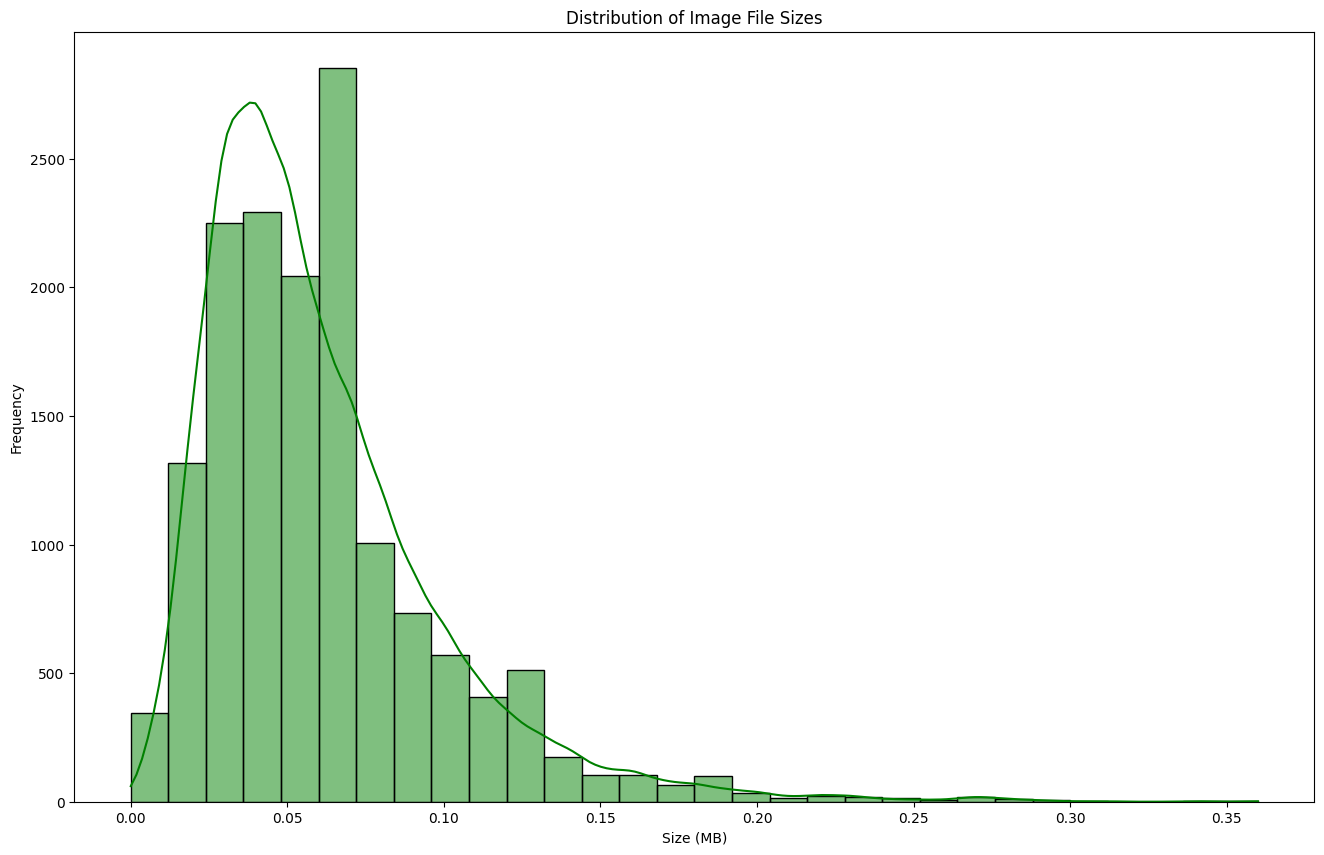

In [121]:
plt.figure(figsize=(16, 10))

# 이미지 파일의 크기 분포를 출력
sns.histplot(image_data['size'], bins=30, kde=True, color='green')
plt.title('Distribution of Image File Sizes')
plt.xlabel('Size (MB)')
plt.ylabel('Frequency')

plt.show()

이미지 파일 크기 분포
- 대부분 이미지 파일 크기는 0.05 ~ 0.1 MB 사이에 분포

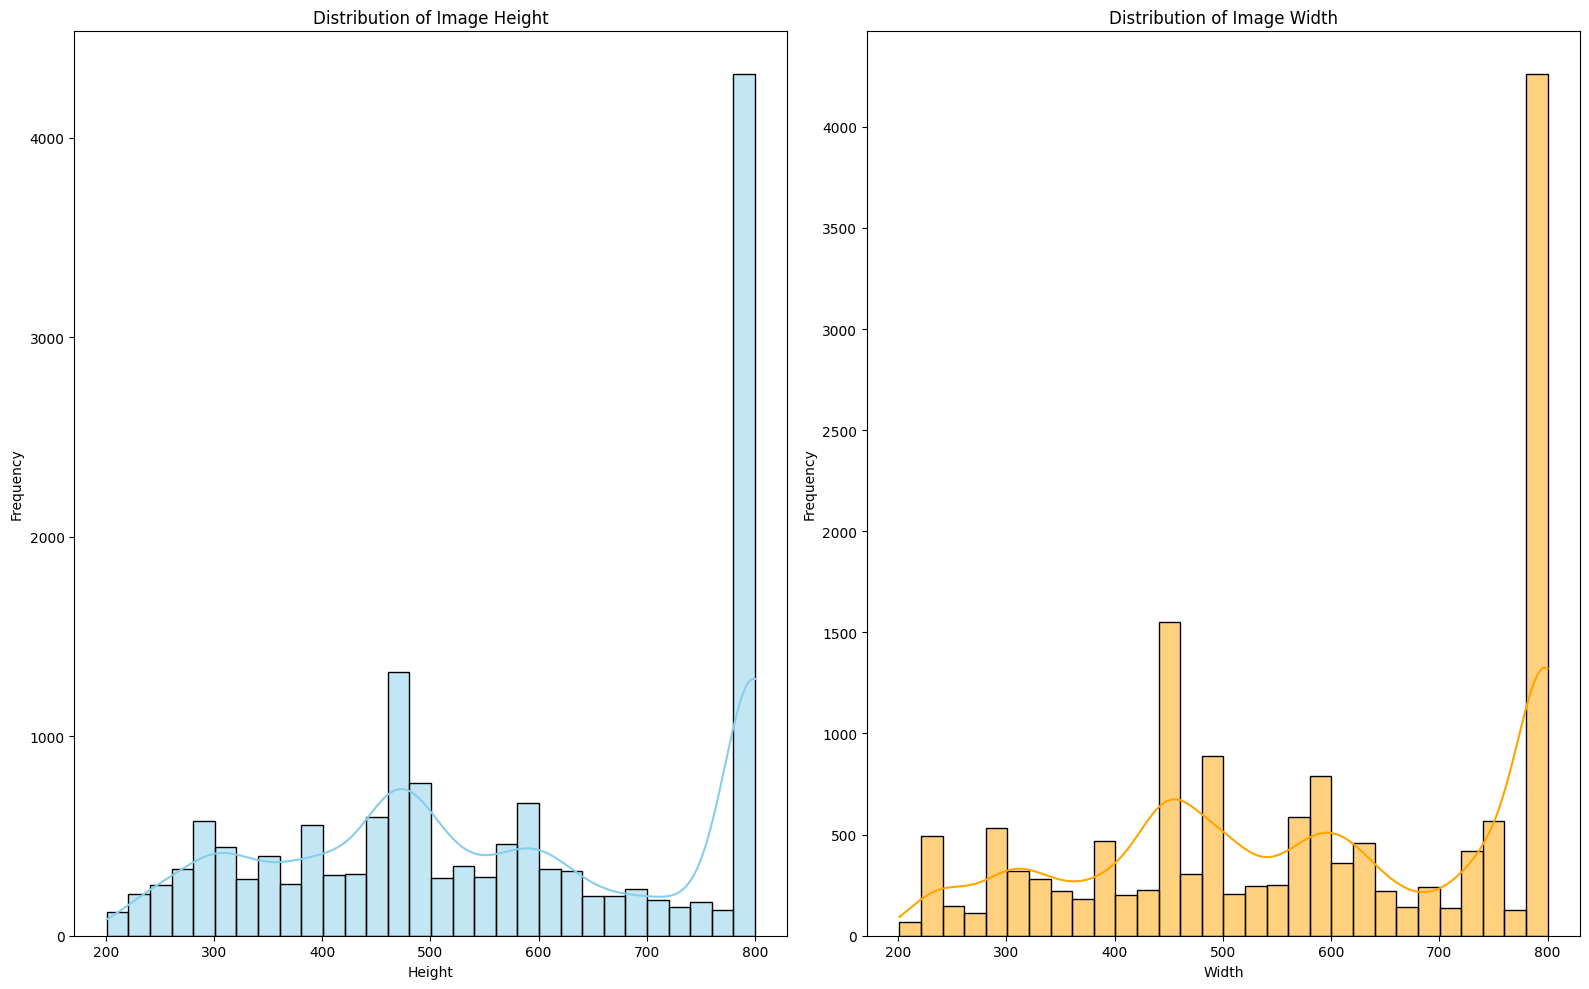

In [122]:
plt.figure(figsize=(16, 10))
# Image height의 분포를 출력
plt.subplot(1, 2, 1)
sns.histplot(image_data['height'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Image Height')
plt.xlabel('Height')
plt.ylabel('Frequency')

# Image width의 분포를 출력
plt.subplot(1, 2, 2)
sns.histplot(image_data['width'], bins=30, kde=True, color='orange')
plt.title('Distribution of Image Width')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

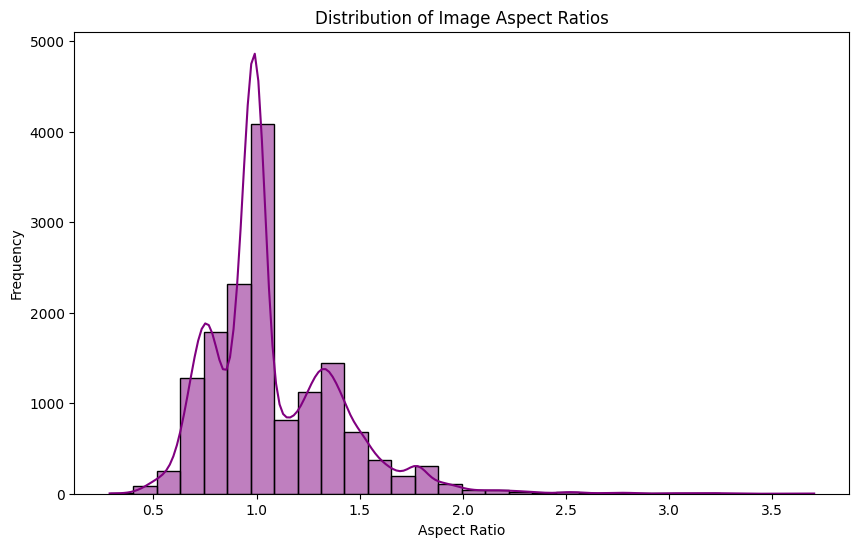

In [123]:
plt.figure(figsize=(10, 6))

# 이미지의 가로 세로 비율을 출력
sns.histplot(image_data['img_aspect_ratio'], bins=30, kde=True, color='purple')
plt.title('Distribution of Image Aspect Ratios')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')

plt.show()


- 가로세로 비율 = 0.8 ~ 1.2 사이 분포

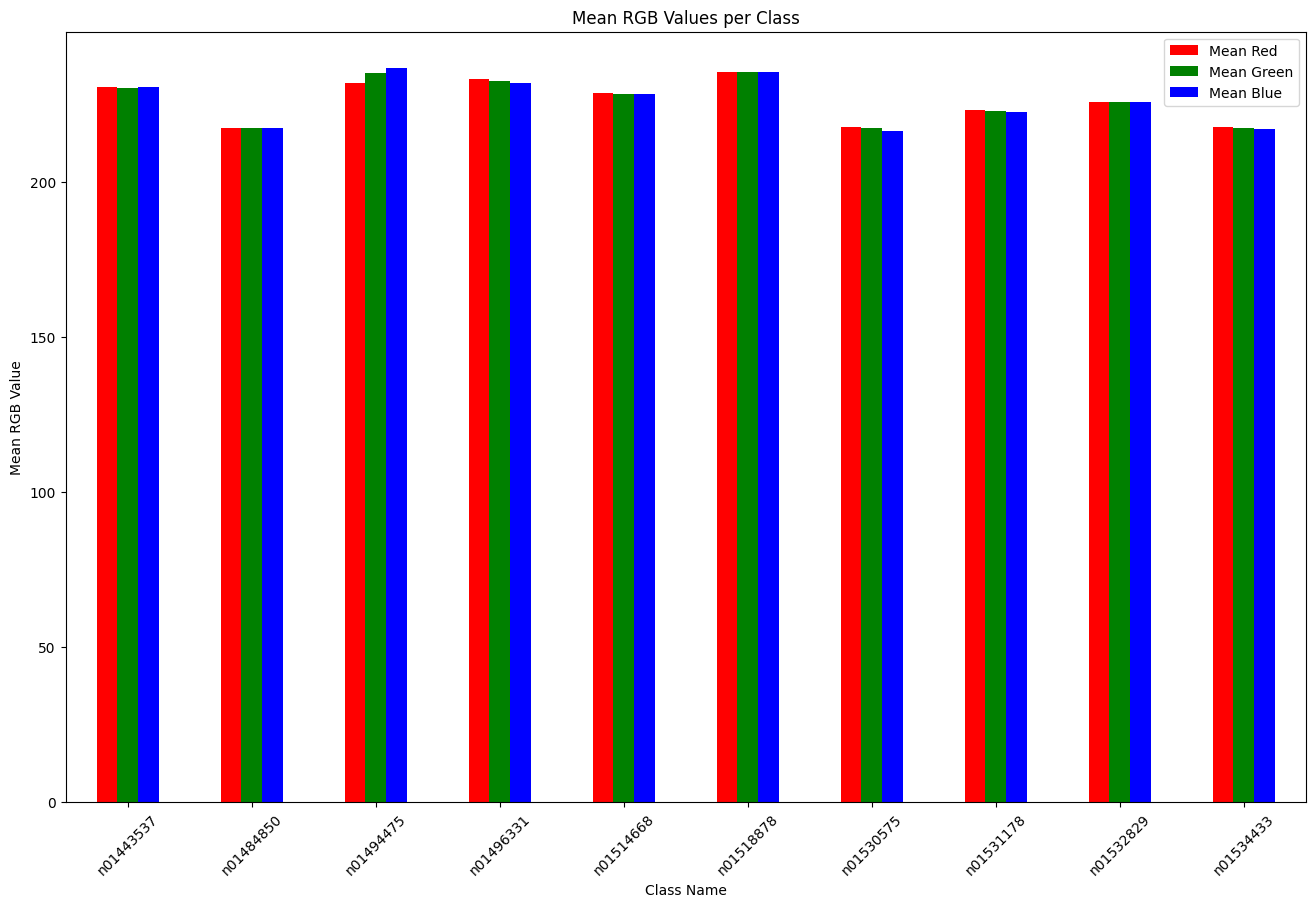

In [124]:
# 10개의 샘플 선택
sample_classes = image_data['class_name'].unique()[:10]

# 각 클래스별로 RGB값의 평균을 계산
mean_rgb_per_class = image_data[image_data['class_name'].isin(sample_classes)].groupby('class_name')[['mean_red', 'mean_green', 'mean_blue']].mean()

# 클래스별로 RGB값의 평균을 출력
mean_rgb_per_class.plot(kind='bar', figsize=(16, 10), color=['red', 'green', 'blue'])
plt.title('Mean RGB Values per Class')
plt.xlabel('Class Name')
plt.ylabel('Mean RGB Value')
plt.xticks(rotation=45)
plt.legend(['Mean Red', 'Mean Green', 'Mean Blue'])
plt.show()


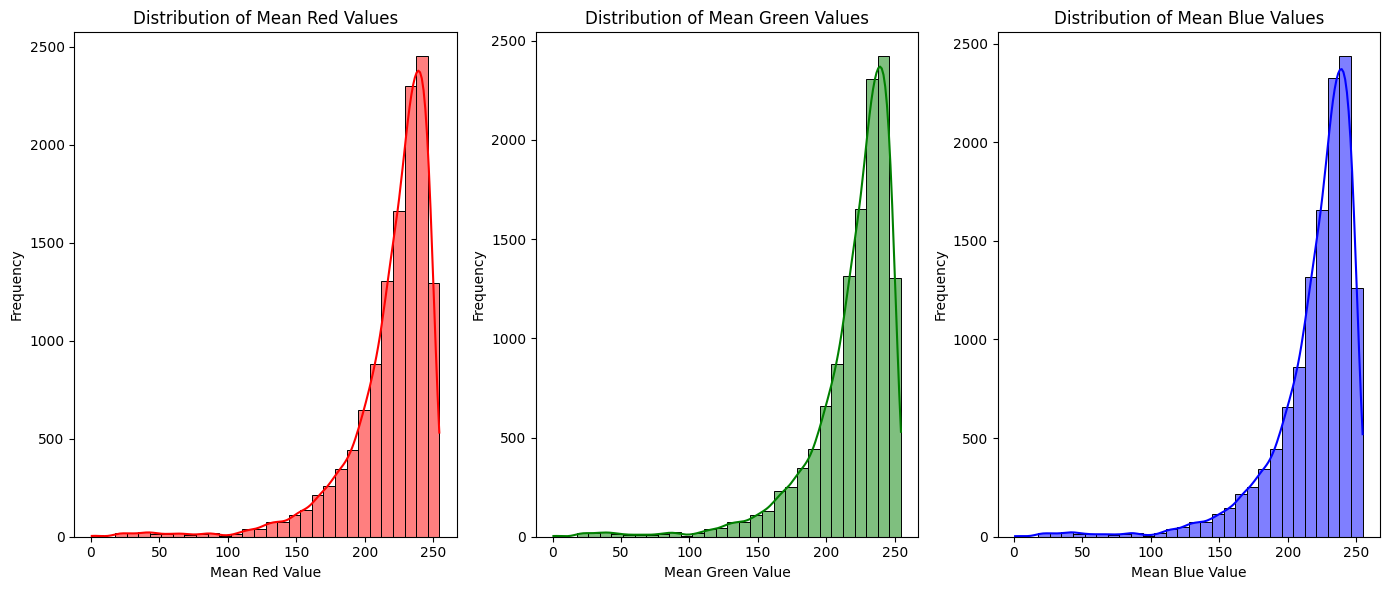

In [125]:
# RGB값의 평균 분포를 출력
plt.figure(figsize=(14, 6))

# mean_red 값의 분포를 출력
plt.subplot(1, 3, 1)
sns.histplot(image_data['mean_red'], bins=30, kde=True, color='red')
plt.title('Distribution of Mean Red Values')
plt.xlabel('Mean Red Value')
plt.ylabel('Frequency')

# mean_green 값의 분포를 출력
plt.subplot(1, 3, 2)
sns.histplot(image_data['mean_green'], bins=30, kde=True, color='green')
plt.title('Distribution of Mean Green Values')
plt.xlabel('Mean Green Value')
plt.ylabel('Frequency')

# mean_blue 값의 분포를 출력
plt.subplot(1, 3, 3)
sns.histplot(image_data['mean_blue'], bins=30, kde=True, color='blue')
plt.title('Distribution of Mean Blue Values')
plt.xlabel('Mean Blue Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


색상 분포 분석
- 대부분 Red, Green, Blue값이 200~250사이에 분포
- 전반적으로 이미지의 밝기와 채도가 높은 편

C:\Users\User\AppData\Local\Temp\ipykernel_9640\2640141684.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='height', y='class_name', data=class_size_stats.sort_values(by='height', ascending=False), palette='viridis')
C:\Users\User\AppData\Local\Temp\ipykernel_9640\2640141684.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='width', y='class_name', data=class_size_stats.sort_values(by='width', ascending=False), palette='viridis')


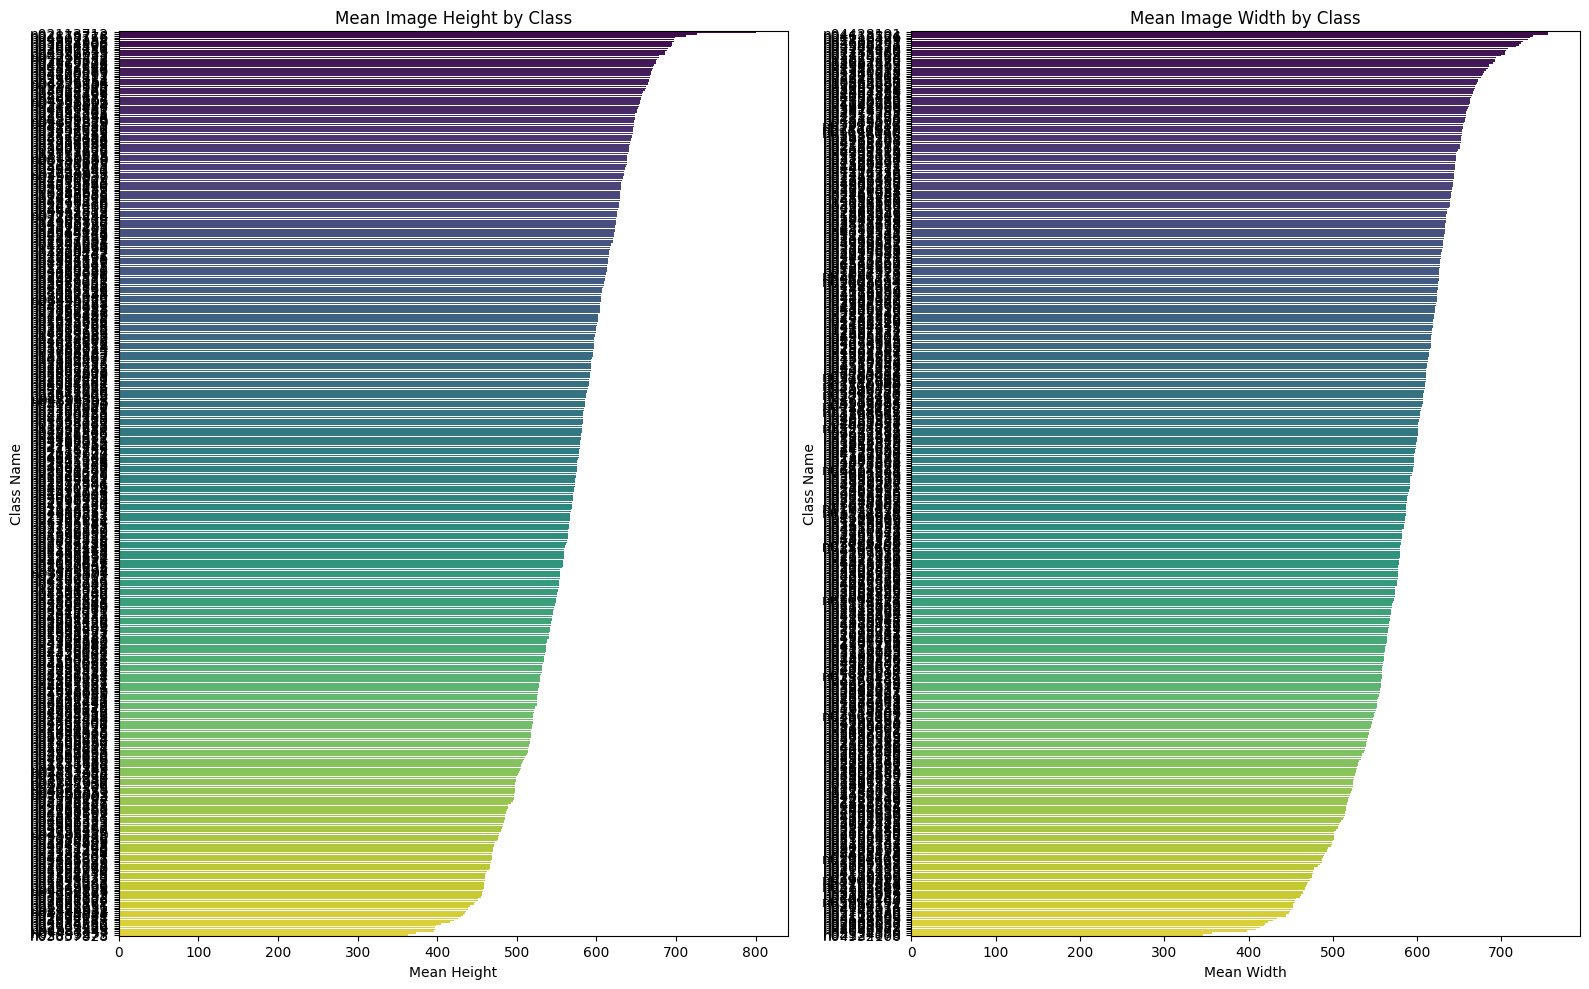

In [126]:
# 각 클래스별로 이미지의 평균 높이와 너비를 계산
class_size_stats = image_data.groupby('class_name')[['height', 'width']].mean().reset_index()

# 각 클래스별로 이미지의 평균 높이와 너비를 출력
plt.figure(figsize=(16, 10))

# 클래스별 이미지의 평균 높이를 출력
plt.subplot(1, 2, 1)
sns.barplot(x='height', y='class_name', data=class_size_stats.sort_values(by='height', ascending=False), palette='viridis')
plt.title('Mean Image Height by Class')
plt.xlabel('Mean Height')
plt.ylabel('Class Name')

# 클래스별 이미지의 평균 너비를 출력
plt.subplot(1, 2, 2)
sns.barplot(x='width', y='class_name', data=class_size_stats.sort_values(by='width', ascending=False), palette='viridis')
plt.title('Mean Image Width by Class')
plt.xlabel('Mean Width')
plt.ylabel('Class Name')

plt.tight_layout()
plt.show()

클래스별 이미지 크기 분포
- 대부분 클래스는 300에서 800 픽셀 사이의 평균 높이를 가지고 있음
- 대부분 클래스느 300에서 800 픽셀 사이의 평균 너비를 가지고 있음

C:\Users\User\AppData\Local\Temp\ipykernel_9640\3931341571.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='mean_red', data=image_data, palette='Reds')
C:\Users\User\AppData\Local\Temp\ipykernel_9640\3931341571.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='mean_green', data=image_data, palette='Greens')
C:\Users\User\AppData\Local\Temp\ipykernel_9640\3931341571.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='mean_blue', data=image_data, palette='Blues')


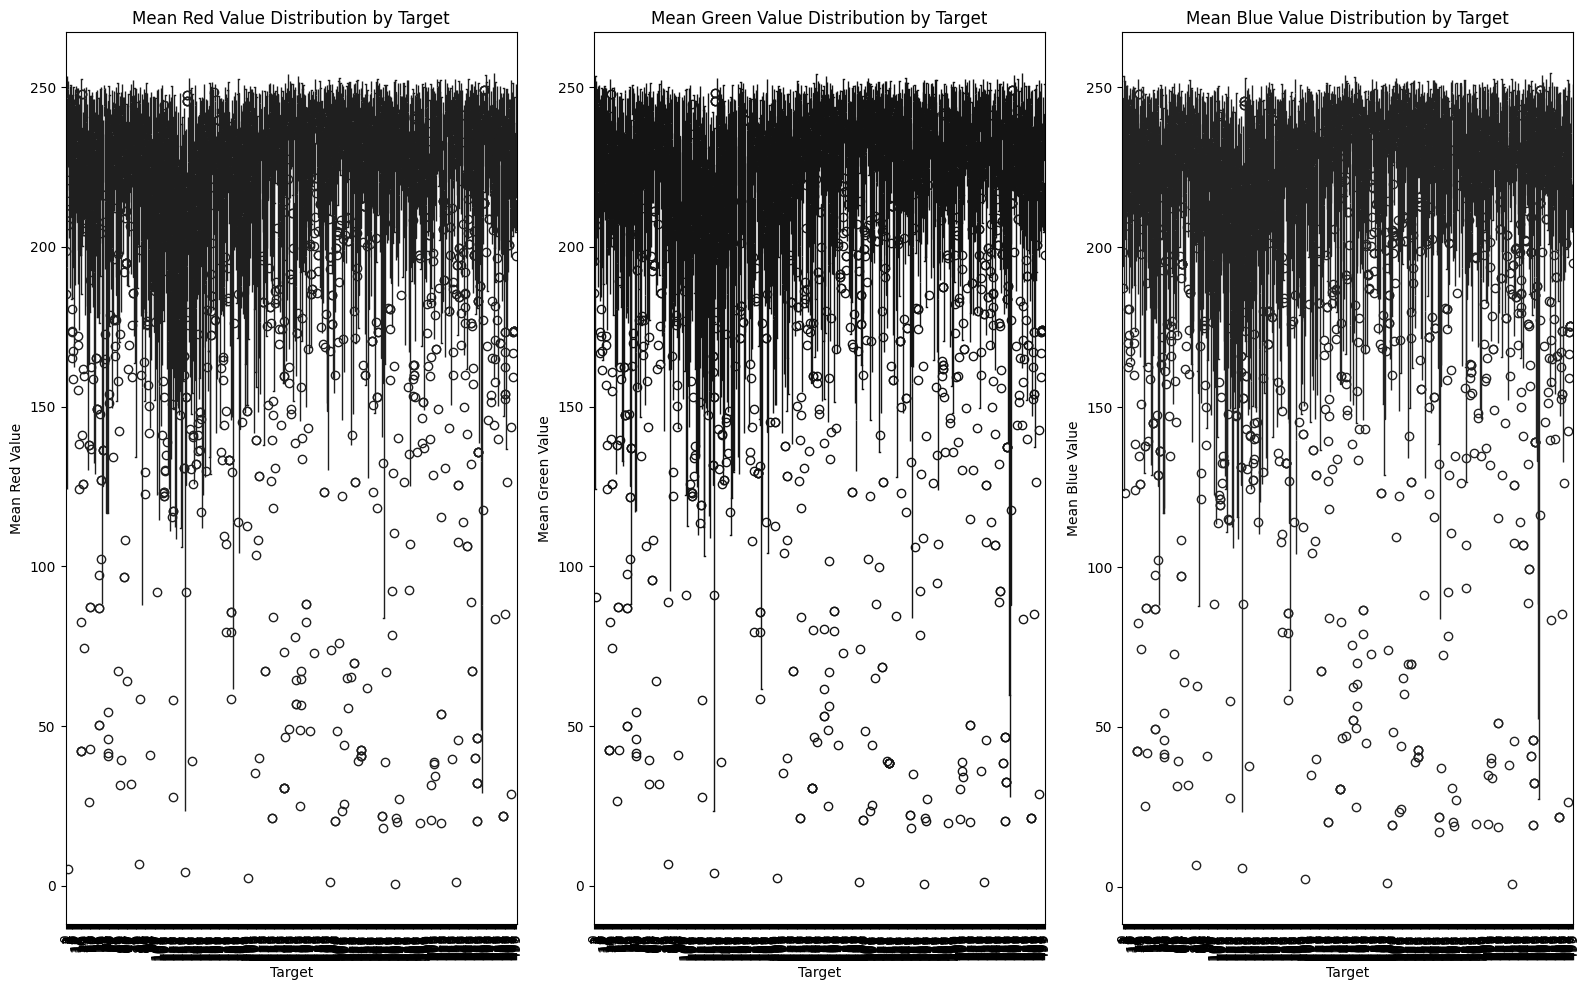

In [127]:
plt.figure(figsize=(16, 10))

# mean_red 값의 분포를 출력
plt.subplot(1, 3, 1)
sns.boxplot(x='target', y='mean_red', data=image_data, palette='Reds')
plt.title('Mean Red Value Distribution by Target')
plt.xlabel('Target')
plt.ylabel('Mean Red Value')
plt.xticks(rotation=90)

# mean_green 값의 분포를 출력
plt.subplot(1, 3, 2)
sns.boxplot(x='target', y='mean_green', data=image_data, palette='Greens')
plt.title('Mean Green Value Distribution by Target')
plt.xlabel('Target')
plt.ylabel('Mean Green Value')
plt.xticks(rotation=90)

# mean_blue 값의 분포를 출력
plt.subplot(1, 3, 3)
sns.boxplot(x='target', y='mean_blue', data=image_data, palette='Blues')
plt.title('Mean Blue Value Distribution by Target')
plt.xlabel('Target')
plt.ylabel('Mean Blue Value')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


클래스별 이미지 색상의 분포
- 대부분 Red, Green, Blue 값은 200에서 250 사이에 분포

### 이미지 출력해보기

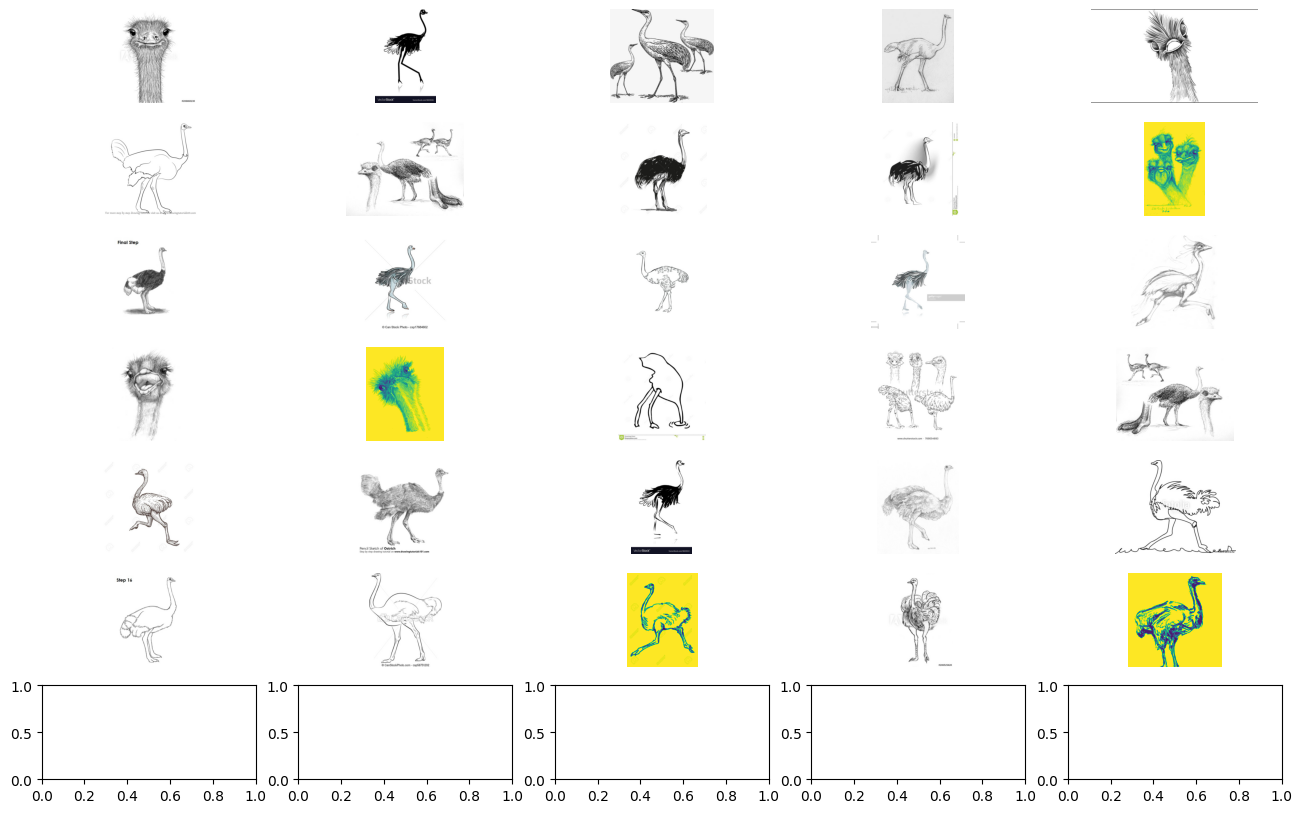

In [128]:
# 같은 target을 가진 이미지 전체 출력
def display_images(data, target):
    len_data = len(data[data['target'] == target])
    fig, axs = plt.subplots((len_data // 5)+1, 5, figsize=(16, 10))
    images = data[data['target'] == target]['path'].values
    for i, path in enumerate(images):
        img = Image.open(path)
        ax = axs[i // 5, i % 5]  # Use double indexing for 2D subplots
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# target이 0인 이미지 출력
display_images(image_data, target=5)

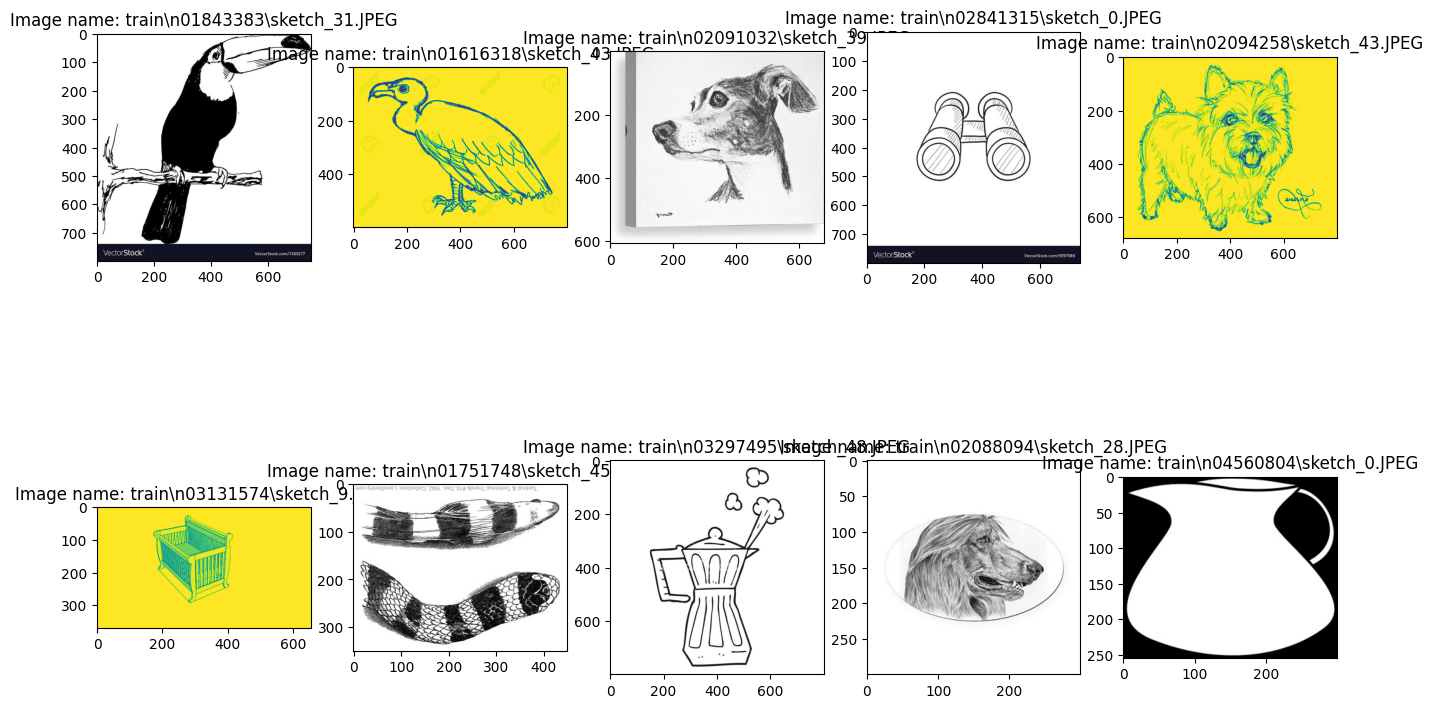

In [129]:
# 이미지를 랜덤으로 5개 출력
plt.style.use('default')
fig, axex = plt.subplots(2, 5, figsize=(16, 10))
for ax in axex.reshape(-1):
    img_path = np.random.choice(train_images)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"Image name: {img_path.split('/')[-1]}")
plt.show()

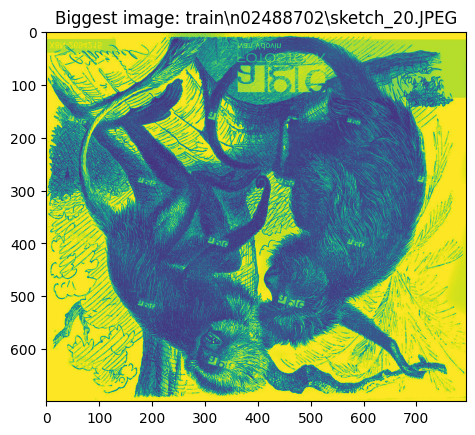

In [130]:
# 가장 큰 이미지를 출력
biggest_img_path = image_data.iloc[image_data['size'].idxmax(),:]['path']

img = Image.open(biggest_img_path)
plt.title(f"Biggest image: {biggest_img_path.split('/')[-1]}")
plt.imshow(img)
del img

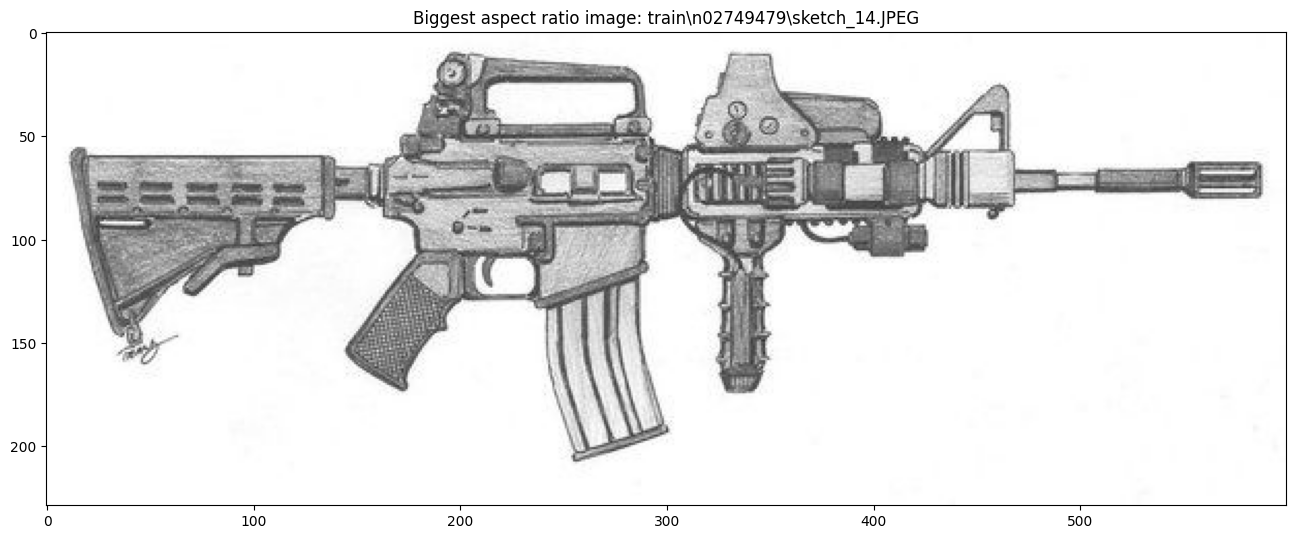

In [131]:
# 이미지의 종횡비가 가장 큰 이미지를 출력
biggest_aspect_ratio_img_path = image_data.iloc[image_data['img_aspect_ratio'].idxmax(),:]['path']

fig, ax = plt.subplots(1, 1, figsize=(16, 10))
img = Image.open(biggest_aspect_ratio_img_path)
plt.title(f"Biggest aspect ratio image: {biggest_aspect_ratio_img_path.split('/')[-1]}")
plt.imshow(img)

In [132]:
# 4개의 작은 이미지를 출력
smallest_img_paths = image_data.nsmallest(4, 'size')['path']
smallest_img_paths.values

array(['./data/train\\n04127249\\sketch_9.JPEG',
       './data/train\\n01484850\\sketch_0.JPEG',
       './data/train\\n01484850\\sketch_34.JPEG',
       './data/train\\n01494475\\sketch_33.JPEG'], dtype=object)

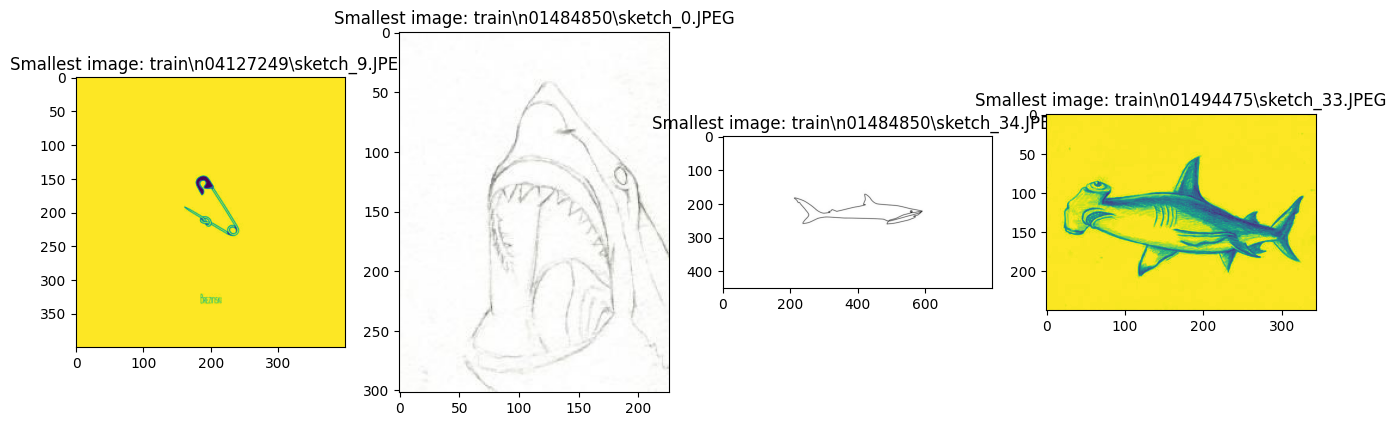

In [133]:
import matplotlib.image as mpimg

# 4개의 작은 이미지를 출력
fig, axes = plt.subplots(1, 4, figsize=(16, 10))
for i, ax in enumerate(axes.reshape(-1)):
    img = mpimg.imread(smallest_img_paths.values[i])
    ax.title.set_text(f"Smallest image: {smallest_img_paths.values[i].split('/')[-1]}")
    ax.imshow(img)
plt.show()

### cv2 활용해서 이미지 분석하기

In [134]:
img_path = train_images[10]
selected_img = image_data[image_data['path'] == img_path]
selected_img

,height,width,mode,format,size,mean_red,mean_green,mean_blue,path,image_path,img_aspect_ratio,class_name,target
10,700,700,RGB,JPEG,0.07,235.5206,235.549143,235.100276,./data/train\n01443537\sketch_26.JPEG,n01443537/sketch_26.JPEG,1.0,n01443537,0


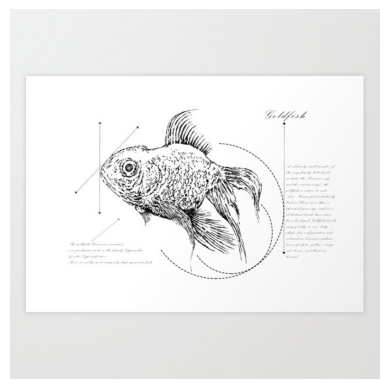

In [135]:
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

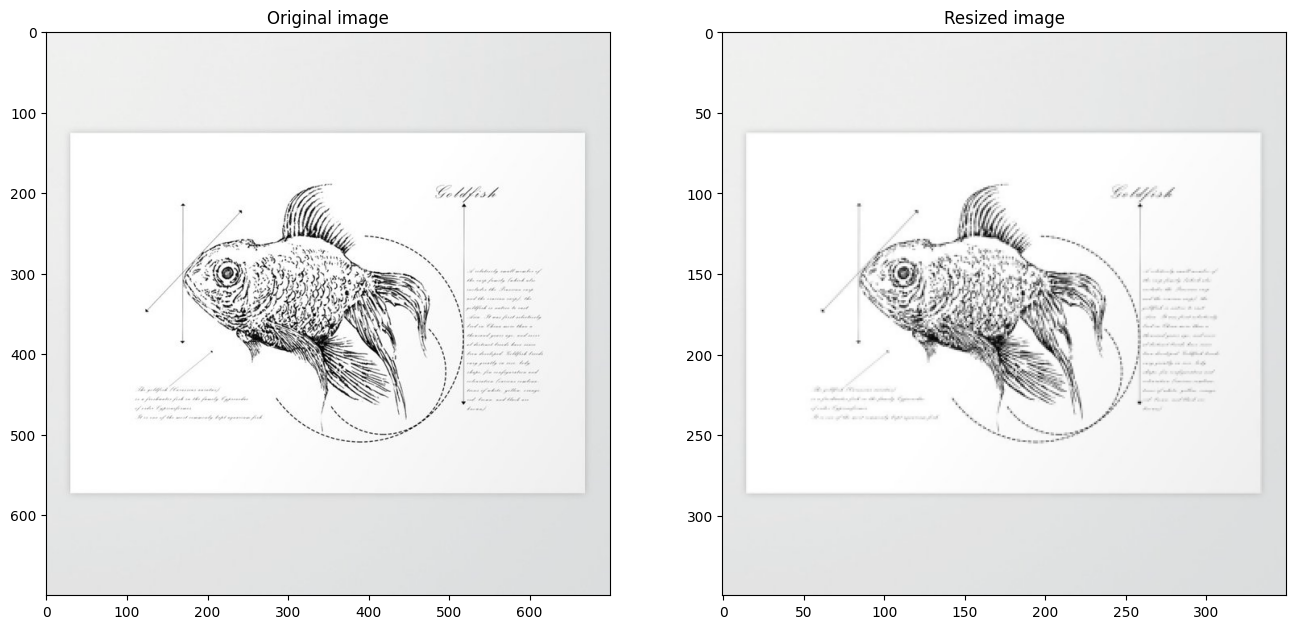

In [136]:
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
resized_img = cv2.resize(img, (0,0), fx=0.5, fy=0.5)

fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax[0].imshow(img)
ax[0].set_title("Original image")
ax[1].imshow(resized_img)
ax[1].set_title("Resized image")
plt.show()

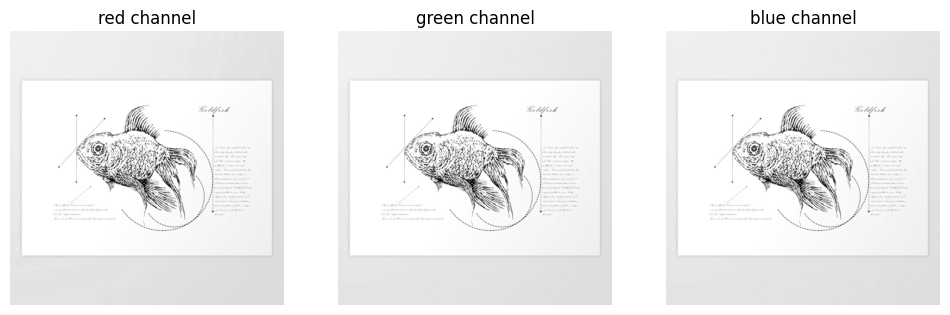

In [137]:
fig, axes = plt.subplots(1,3, figsize=(12,12))
colors = ['red', 'green', 'blue']
for i, ax in enumerate(axes):
    ax.imshow(img[:,:,i], cmap='gray')
    ax.set_title(colors[i]+' channel'), ax.axis('off')
plt.show()

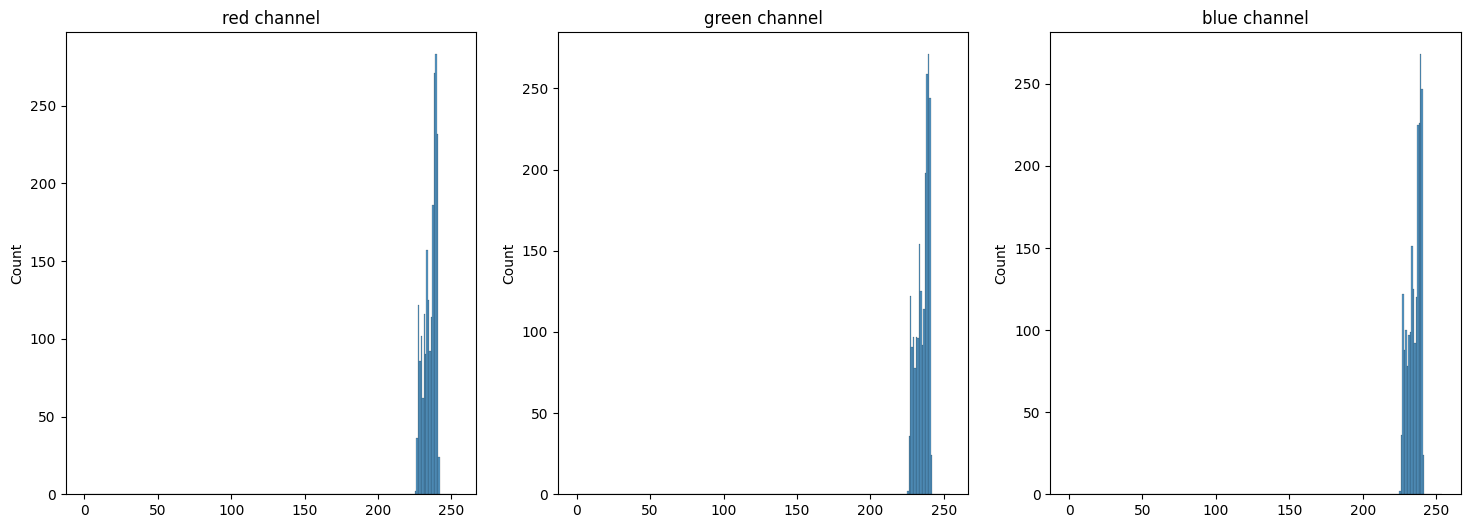

In [138]:
fig, axes = plt.subplots(1,3, figsize=(18,6))
for i, ax in enumerate(axes):
    df = img[i].ravel()
    sns.histplot(df, bins=np.arange(0,255), ax=ax)
    ax.set_title(colors[i]+' channel')
plt.show()

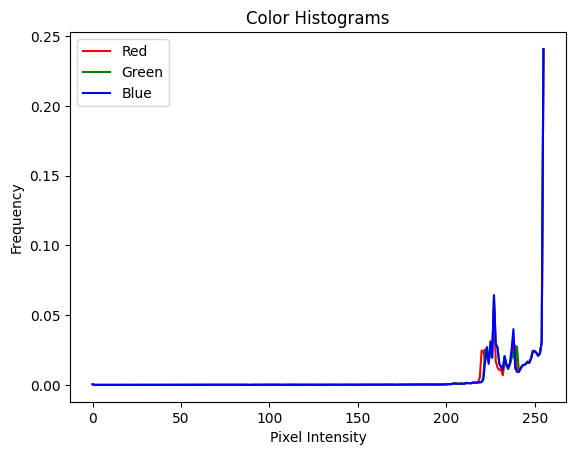

In [139]:
# Compute color histograms for each channel
hist_red, bins_red = np.histogram(img[:, :, 0], bins=256, range=(0, 256), density=True)
hist_green, bins_green = np.histogram(img[:, :, 1], bins=256, range=(0, 256), density=True)
hist_blue, bins_blue = np.histogram(img[:, :, 2], bins=256, range=(0, 256), density=True)

# Plot color histograms
plt.plot(bins_red[:-1], hist_red, color='red', label='Red')
plt.plot(bins_green[:-1], hist_green, color='green', label='Green')
plt.plot(bins_blue[:-1], hist_blue, color='blue', label='Blue')
plt.title('Color Histograms')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [140]:
height, width, channels = img.shape
print(f"Image Height:", height)
print(f"Image Width:", width)
print(f"Image Channels:", channels)
print(f"Image Shape: {height} x {width} x {channels}")

Image Height: 700
Image Width: 700
Image Channels: 3
Image Shape: 700 x 700 x 3


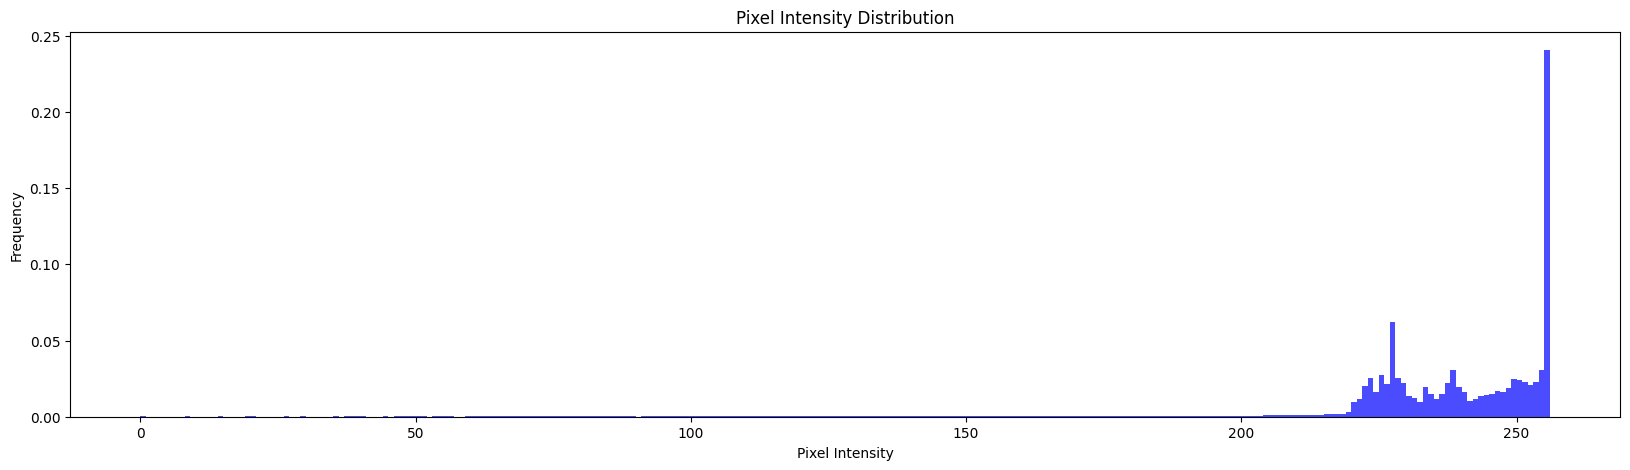

In [141]:
# pixel intensity의 분포 출력
plt.figure(figsize = (20, 5))
plt.hist(img.flatten(), bins=256, range=(0, 256), density=True, color='blue', alpha=0.7)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

In [142]:
!pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skimage\_shared\utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


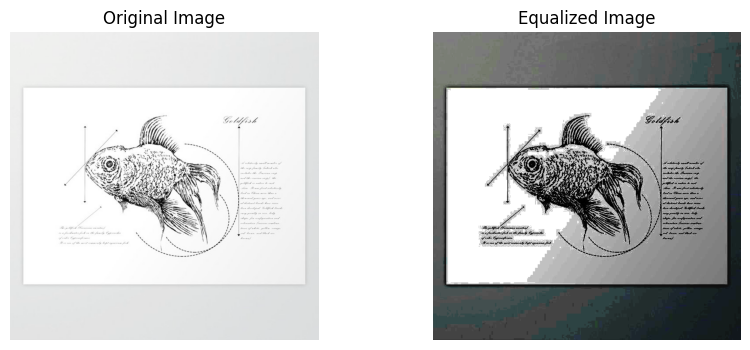

In [143]:
from skimage import exposure

# Apply histogram equalization
img_eq = exposure.equalize_hist(img)

# Display original and equalized images
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(img_eq)
axes[1].set_title('Equalized Image')
axes[1].axis('off')

plt.show()

- Image HIstogram Equalization
    - 이미지의 밝기 값에 대한 히스토그램을 계산한 후, 픽셀 값의 분포를 넓혀 전체 범위에 균등하게 분포되도록 함으로써 이미지의 어두운 부분과 밝은 부분의 디테일을 향상시켜주는 방식

배경 색이 다른 이미지도 분석해보기

In [159]:
img_path = train_images[16]
selected_img = image_data[image_data['path'] == img_path]
selected_img

,height,width,mode,format,size,mean_red,mean_green,mean_blue,path,image_path,img_aspect_ratio,class_name,target
16,800,800,L,JPEG,0.05,NaN,NaN,NaN,./data/train\n01443537\sketch_35.JPEG,n01443537/sketch_35.JPEG,1.0,n01443537,0


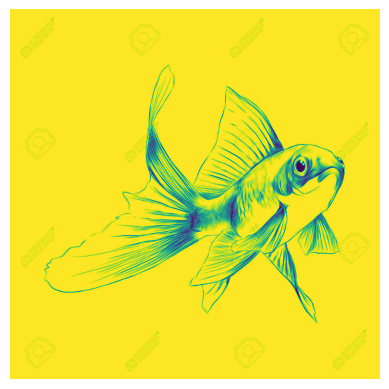

In [160]:
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [163]:
image_data['mode'].value_counts()

mode
RGB    12443
L       2578
Name: count, dtype: int64

- 배경 색이 존재하는 이미지의 mode는 L(흑백)
    - 배경 색이 존재하는 이미지를 이상치로 삼기엔 너무 많음.